<a href="https://colab.research.google.com/github/geunsu-jo/KCYPS_project/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/train_data.xlsx")
test_data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test_data.xlsx")

In [3]:
train_data.shape, test_data.shape

((1950, 68), (488, 68))

__target 변수와 상관관계가 높은 상위 5개 문항__

In [4]:
cor_matrix = train_data.corr()
np.abs(cor_matrix["y"]).sort_values(ascending=False).head(10)

y             1.000000
YDLQ2A01w2    0.370374
YDLQ2A11w2    0.274998
YPSY4B02w2    0.183792
YPSY4B04w2    0.176393
YPSY4B05w2    0.158071
YPSY4C05w2    0.154201
YINT2B16w2    0.150872
YPSY4A02w2    0.147855
YPSY4A01w2    0.146561
Name: y, dtype: float64

__target__ 데이터 생성

In [5]:
y_train = train_data["y"]
y_test = test_data["y"]

__feature__데이터 생성

In [6]:
X_train = train_data.drop(['y'], axis=1)
X_test = test_data.drop(['y'], axis=1)
X_train.head()

,YTIM1B02w2,YTIM1C02w2,YTIM1D02w2,YTIM1E02w2,YTIM1G02w2,YTIM1H02w2,YTIM1J02w2,YTIM1K01w2,YTIM1K02w2,YTIM1L02w2,YTIM1N01w2,YTIM1N02w2,YINT2B08w2,YINT2B16w2,YFUR1A00w2,YFUR1B00w2,YFUR2A06w2,YPSY4A01w2,YPSY4A02w2,YPSY4B02w2,YPSY4B04w2,YPSY4B05w2,YPSY4C02w2,YPSY4C03w2,YPSY4C05w2,YPSY4C08w2,YPSY5A05w2,YPSY5A06w2,YPSY6A08w2,YPSY6A20w2,YPSY6A30w2,YDLQ2A01w2,YDLQ2A11w2,YPHY1B00w2,YPHY1C00w2,YPHY2A00w2,YPHY2C00w2,YMDA1B02w2,YMDA1B05w2,YMDA1B06w2,YMDA1B07w2,YMDA1B08w2,YMDA1B09w2,YMDA1B11w2,YMDA1B12w2,YMDA1C01w2,YMDA1C02w2,YMDA1C08w2,YMDA1C12w2,YMDA1C14w2,YMDA1C15w2,YACT1A03w2,YACT1A05w2,YACT1A06w2,YEDU2A09w2,YEDU2A11w2,YEDU3A01w2,YEDU3A04w2,YEDU3A05w2,YEDU3A06w2,YEDU3A07w2,YEDU3A10w2,YFAM2F02w2,YFAM2F03w2,YFAM2F04w2,PPSY1A02w2,PPHY1A00w2
0,0,3,3,1,1,4,1,4,5,2,4,4,2,2,5,1,2,2,2,2,2,2,2,2,2,2,3,3,0,1,0,1,1,1,6,159,5,3,4,1,3,4,4,2,2,3,2,2,2,3,2,1,1,1,2,2,2,2,3,2,3,2,2,2,3,4,3
1,0,3,5,1,1,5,5,6,6,6,5,6,2,2,3,1,1,2,2,2,2,2,2,2,3,2,4,3,0,0,0,1,1,2,6,165,1,3,2,4,3,3,4,3,4,2,3,2,2,3,2,1,1,1,3,3,3,3,3,2,3,3,3,2,2,2,4
2,0,4,4,1,1,4,3,4,4,3,4,5,1,1,3,3,2,3,2,2,1,1,1,2,1,2,3,4,0,1,0,1,1,2,3,163,6,4,3,2,3,3,4,3,2,2,2,1,1,1,3,1,2,1,1,2,3,2,2,2,3,2,2,2,1,3,3
3,0,4,4,1,1,3,2,6,7,6,2,5,3,4,3,1,1,2,3,2,2,1,1,4,2,1,1,1,0,1,1,1,1,1,0,168,1,3,1,4,3,4,3,4,3,3,3,2,1,4,1,2,3,1,2,2,1,3,2,3,3,2,3,3,2,3,4
4,50,3,3,1,1,3,1,4,5,2,2,1,3,3,3,1,2,2,3,2,3,2,3,1,3,3,3,2,0,0,0,1,1,2,2,158,2,3,3,2,3,2,3,2,2,2,3,2,3,2,2,2,2,1,3,2,2,2,3,2,3,2,2,2,3,3,3


__표준화__(랜포에선 하나마나)

In [7]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

## 랜포

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

param_rfc = {'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 50, 70, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4, 6],
             'min_samples_split': [2, 4, 6],
             'n_estimators': [100, 150, 200, 250, 300, 400, 500, 600, 800, 1000]
}

rfc = RandomForestClassifier(n_jobs=-1, random_state=64)
rnd_search_rfc = RandomizedSearchCV(rfc, param_rfc, n_iter=64, cv=5, 
                           scoring="roc_auc", random_state=42,
                           return_train_score=True)
rnd_search_rfc.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [18]:
rnd_search_rfc.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 600}

In [19]:
from sklearn.metrics import roc_curve

pred_rf_proba = rnd_search_rfc.best_estimator_.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thr = roc_curve(y_test, pred_rf_proba)

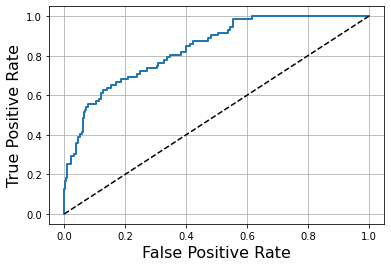

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
                          
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)     
    plt.grid(True)                                   


plot_roc_curve(fpr, tpr)

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred_rf_proba)

0.8355368589743589

## SVM

In [2]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-q08rkg84
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-q08rkg84
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/15/c4/1310a054d33abc318426a956e7d6df0df76a6ddfa9c66f6310274fb75d42/pyaml-20.4.0-py2.py3-none-any.whl
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.dev0-cp36-none-any.whl size=102003 sha256=b90a4a59720fba331dba7544074aa2a9f9b79a3ecd1bb6b056b480fa19908747
  Stored in directory: /tmp/pip-ephem-wheel-cache-wncm2nl4/wheels/11/6f/86/2b772172db85ad0b4487d67e325e535ee8e7782b2a1dfcadf5
Successfully built scikit-optimize


In [3]:
# Assuring you have the most recent CatBoost release
!pip install catboost -U

     |████████████████████████████████| 65.8MB 59kB/s 


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.svm import SVC

param_svm ={
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  
        'kernel': ['linear', 'poly', 'rbf']
}
svc = SVC(probability=True, random_state=42)

rnd_search_svc = BayesSearchCV(svc, param_svm, n_iter=3, cv=5,
                                   scoring="roc_auc", random_state=42,
                                   return_train_score=True) # n_iter는 파라미터공간에서 선택할(반복할) 파라미터 수
rnd_search_svc.fit(X_train_scaled, y_train)

BayesSearchCV(cv=5, error_score='raise',
              estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                            class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3,
                            gamma='scale', kernel='rbf', max_iter=-1,
                            probability=True, random_state=42, shrinking=True,
                            tol=0.001, verbose=False),
              fit_params=None, iid=True, n_iter=3, n_jobs=1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
              refit=True, return_train_score=True, scoring='roc_auc',
              search_spaces={'C': (1e-06, 1000000.0, 'log-uniform'),
                             'degree': (1, 8),
                             'gamma': (1e-06, 10.0, 'log-uniform'),
                             'kernel': ['linear', 'poly', 'rbf']},
              verbose=0)

In [9]:
rnd_search_svc.best_params_

OrderedDict([('C', 11185.625288472094),
             ('degree', 7),
             ('gamma', 0.00013300585802877296),
             ('kernel', 'rbf')])

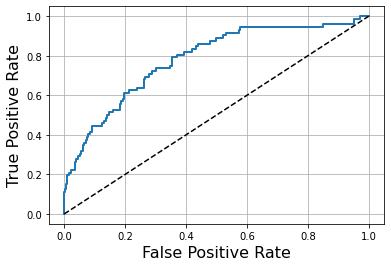

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
                          
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)     
    plt.grid(True)      

pred_svc_proba = rnd_search_svc.best_estimator_.predict_proba(X_test_scaled)[:,1]

fpr, tpr, thr = roc_curve(y_test, pred_svc_proba)
plot_roc_curve(fpr, tpr)

In [11]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred_svc_proba)

0.7812166132478632